In [4]:
using PyPlot

In [15]:
function Adams_Bashforth(f, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)
  
    t[1] =t0
    y[:,1]=y0
    
      for i = 1:3
        t[i+1]=y[i]+h
        k_1=f(t[i],y[:,i])
        k_2=f(t[i]+0.5*h,y[:,i]+0.5*h*k_1)
        k_3=f(t[i]+0.5*h,y[:,i]+0.5*h*k_2)
        k_4=f(t[i+1],y[:,i]+h*k_3)
        y[:,i+1]=y[:,i]+h/6.*(k_1+2*k_2+2*k_3+k_4)
    end
    for i=4:N
        t[i+1]=t[i]+h
        y[:,i+1]=y[:,i]+h/24.*(55*f(t[i],y[:,i])-59*f(t[i-1],y[:,i-1])+37*f(t[i-2],y[:,i-2])-9*f(t[i-3],y[:,i-3]))
    end
    return (t,y)
end

Adams_Bashforth (generic function with 1 method)

In [16]:
function Adams_moulton(f, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)
  
    m = zeros(1, N + 1) # value of Moulton's device
    t[1] =t0
    y[:,1]=y0
    
    for i = 1:3
        t[i+1]=y[i]+h
        k_1=f(t[i],y[:,i])
        k_2=f(t[i]+0.5*h,y[:,i]+0.5*h*k_1)
        k_3=f(t[i]+0.5*h,y[:,i]+0.5*h*k_2)
        k_4=f(t[i+1],y[:,i]+h*k_3)
        y[:,i+1]=y[:,i]+h/6.*(k_1+2*k_2+2*k_3+k_4)
    end
    
    for i=4:N
        t[i+1]=t[i]+h
        yh=y[:,i]+h/24.*(55*f(t[i],y[:,i])-59*f(t[i-1],y[:,i-1])+37*f(t[i-2],y[:,i-2])-9*f(t[i-3],y[:,i-3]))
        y[:i+1]=y[:,i]+h/24.*(9*f(t[i],y[:,i])+19*f(t[i-1],y[:,i-1])-5*f(t[i-2],y[:,i-2])+f(t[i-3],y[:,i-3]))
        m[i+1]=251./((251.+19.)*h)*norm(y[:i+1]-yp)
    end
    return (t,y)
end



Adams_moulton (generic function with 1 method)

In [21]:
#
# Predictor Corrector method using 4th order
# Adams-Bashforth and Adams-Moulton. Starting
# values computed with Runge Kutta 4th order.
# Parameters:
#   f  - right hand side of ODE
#   t0 - initial time
#   y0 - initial value
#   h  - step size
#   T  - final time
#   k  - number of corrector steps
#
function PECE(f, t0, y0, h, T, k=1)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)
    fs = zeros(d, N + 1) # value of f at (t[i],y[:,i])
    m = zeros(1, N + 1) # value of Milne's device

    # Initial values:
    t[1] = t0
    y[:,1] = y0
    fs[:,1] = f(t0, y0)

    # Compute the first three steps with RK4:
    for i = 1:min(3, N)
        t[i+1] = t[i] + h
        
        k_1 = f(t[i], y[:,i])
        k_2 = f(t[i] + 0.5*h, y[:,i] + 0.5 * h * k_1)
        k_3 = f(t[i] + 0.5*h, y[:,i] + 0.5 * h * k_2)
        k_4 = f(t[i+1], y[:,i] + h * k_3)
        
        y[:,i+1] = y[:,i] + h * 1/6. * (k_1 + 2*k_2 + 2*k_3 + k_4)
        fs[:,i+1] = f(t[i+1], y[:,i+1])
    end
    
    # For the remaining steps use a PECE scheme:
    for i = 4:N
        t[i+1] = t[i] + h
        
        # Predictor: Adams-Bashforth 4th order
        yP = y[:,i] + h / 24. * (55. * fs[i] - 59. * fs[i-1] + 37. * fs[i-2] - 9. * fs[i-3])
        
        # Now, do k corrector steps:
        yC = yP
        for j = 1:k
            # Estimate:
            fC = f(t[i+1], yC)
            
            # Corrector: Adams-Moulton 4th order
            yC = y[:,i] + h / 24. * (9. * fC + 19. * fs[i] - 5. * fs[i-1] + 1. * fs[i-2])
        end
        
        y[:,i+1] = yC
        fs[:,i+1] = f(t[i+1], y[:,i+1])
        
        # Milne's device:
        m[i+1] = 251. / (251. + 19.) / h * norm(yC - yP)
    end
    
    return (t, y, f, m)
end

PECE (generic function with 2 methods)

In [37]:
#
# (Explicit) Forward Euler scheme:
# f  - rhs of differential equation
# df - Jacobian matrix of f (not used)
# t0 - Initial time
# y0 - Initial value
# h  - step length
# T  - right boundary of time interval [t0,T]
#
function forward_euler(f, df, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)

    # Initial values:
    t[1] = t0
    y[:,1] = y0

    for i = 1:N
        t[i+1] = t[i] + h
        y[:,i+1] = y[:,i] + h * f(t[i], y[:,i])
    end
    
    return (t, y)
end

forward_euler (generic function with 1 method)

In [38]:
function trapezoidal_rule(f, df, t0, y0, h, T)
    d = length(y0)
    N = convert(Int64, floor((T-t0)/h))
    
    t = zeros(1, N + 1)
    y = zeros(d, N + 1)
    
    # Initial values:
    t[1] = t0
    y[:,1] = y0
    
    for i=1:N
        t[i+1]=t[i]+h
        y[:,i+1]=y[:,i]+ h/2.*(f(t[i], y[:,i])+f(t[i+1], y[:,i+1]))
    end
    return (t, y)
end

trapezoidal_rule (generic function with 1 method)

In [22]:
f(t, x) = [
    -200 * t * x[1]^2;
]

x(t) = 1 / (1 + 100*t^2)

t0 = -3.
y0 = [ 1./901; ]
T = 3.;

In [30]:
for i=1:6
    h=0.4/(2^i)
    t,y,f,m = PECE(f, t0, y0, h, T, 1)
    error1=norm(x(T)-y[:,end])
    println("h = ",h)
    println("4th oder 1 correct step error = ", error1)
end
m

h = 0.2
4th oder 1 correct step error = NaN
h = 0.1
4th oder 1 correct step error = NaN
h = 0.05
4th oder 1 correct step error = 6.670029152441664e-5
h = 0.025
4th oder 1 correct step error = 8.692544600785723e-10
h = 0.0125
4th oder 1 correct step error = 1.4968234984813478e-13
h = 0.00625
4th oder 1 correct step error = 1.0542781925249045e-14


1×961 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.77933e-12  1.80423e-12  …  1.81646e-12  1.79007e-12

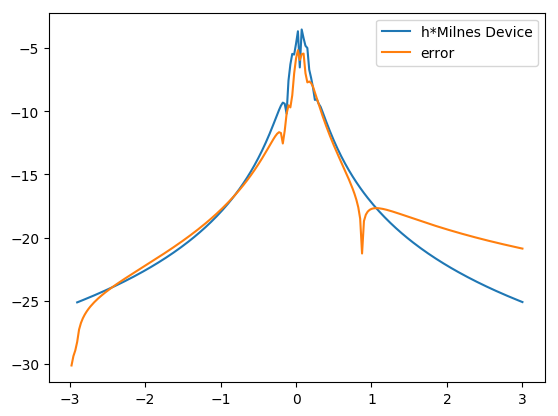

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] include_string(::Module, ::String, ::String) at /home/juser/.julia/v0.6/Compat/src/Compat.jl:464
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[36], in expression starting on line 4


PyObject <matplotlib.legend.Legend object at 0x7fd415d90f10>

In [36]:
h=0.025
t,y,f,m = PECE(f, t0, y0, h, T, 1)
error = [ norm(x(t[i]) - y[:,i]) for i=1:length(t)]
plot(t',log(h*m[1,:]),label="h*Milnes Device")
plot(t', log.(error), label="error")
legend()


In [40]:
A = [
    -21   19  -20;
     19  -21   20;
     40  -40  -40;
]

f(t, x) = A * x
df(t, x) = A
t0=0
y0=[1.;0.;-1.]
T=2


2

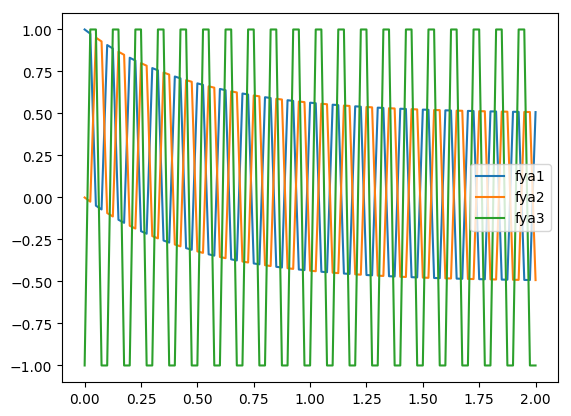

PyObject <matplotlib.legend.Legend object at 0x7fd4144313d0>

In [44]:
h=0.025
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=trapezoidal_rule(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

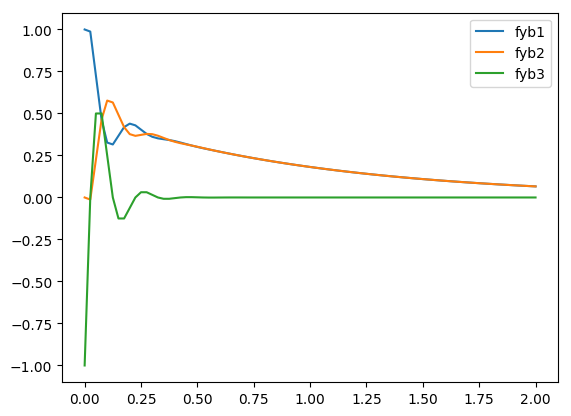

PyObject <matplotlib.legend.Legend object at 0x7fd412ad8390>

In [46]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

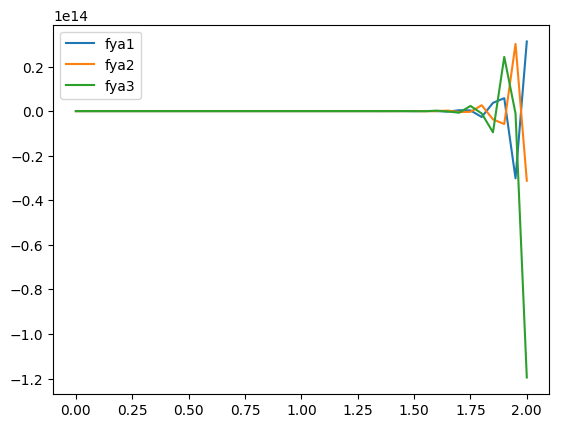

PyObject <matplotlib.legend.Legend object at 0x7fd4129c3f90>

In [47]:
h=0.05
ta,ya=forward_euler(f, df, t0, y0, h, T)
tb,yb=trapezoidal_rule(f, df, t0, y0, h, T)
plot(ta', ya[1,:], label="fya1")
plot(ta', ya[2,:], label="fya2")
plot(ta', ya[3,:], label="fya3")
legend()

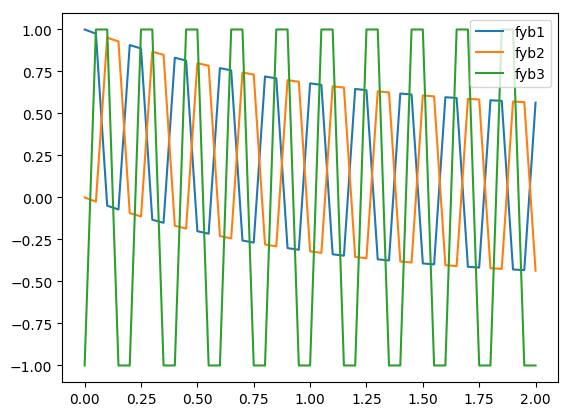

PyObject <matplotlib.legend.Legend object at 0x7fd412916e90>

In [48]:
plot(tb', yb[1,:], label="fyb1")
plot(tb', yb[2,:], label="fyb2")
plot(tb', yb[3,:], label="fyb3")
legend()

In [49]:
ω(z) = 1. + z + 1./2 * z^2
function check_point(z)
    if abs(ω(z)) <= 1
        return 0
    else
        return 1
    end
end

check_point (generic function with 1 method)

In [50]:
compute_stability_region(lower_left, upper_right, resolution=800) =
[ check_point(complex(j,i))
    for i = linspace(upper_right.im, lower_left.im, resolution),
        j = linspace(lower_left.re, upper_right.re, resolution)
]

compute_stability_region (generic function with 2 methods)

In [51]:
(lower_left, upper_right) = (-4-4im, 4+4im)
S = compute_stability_region(lower_left, upper_right);

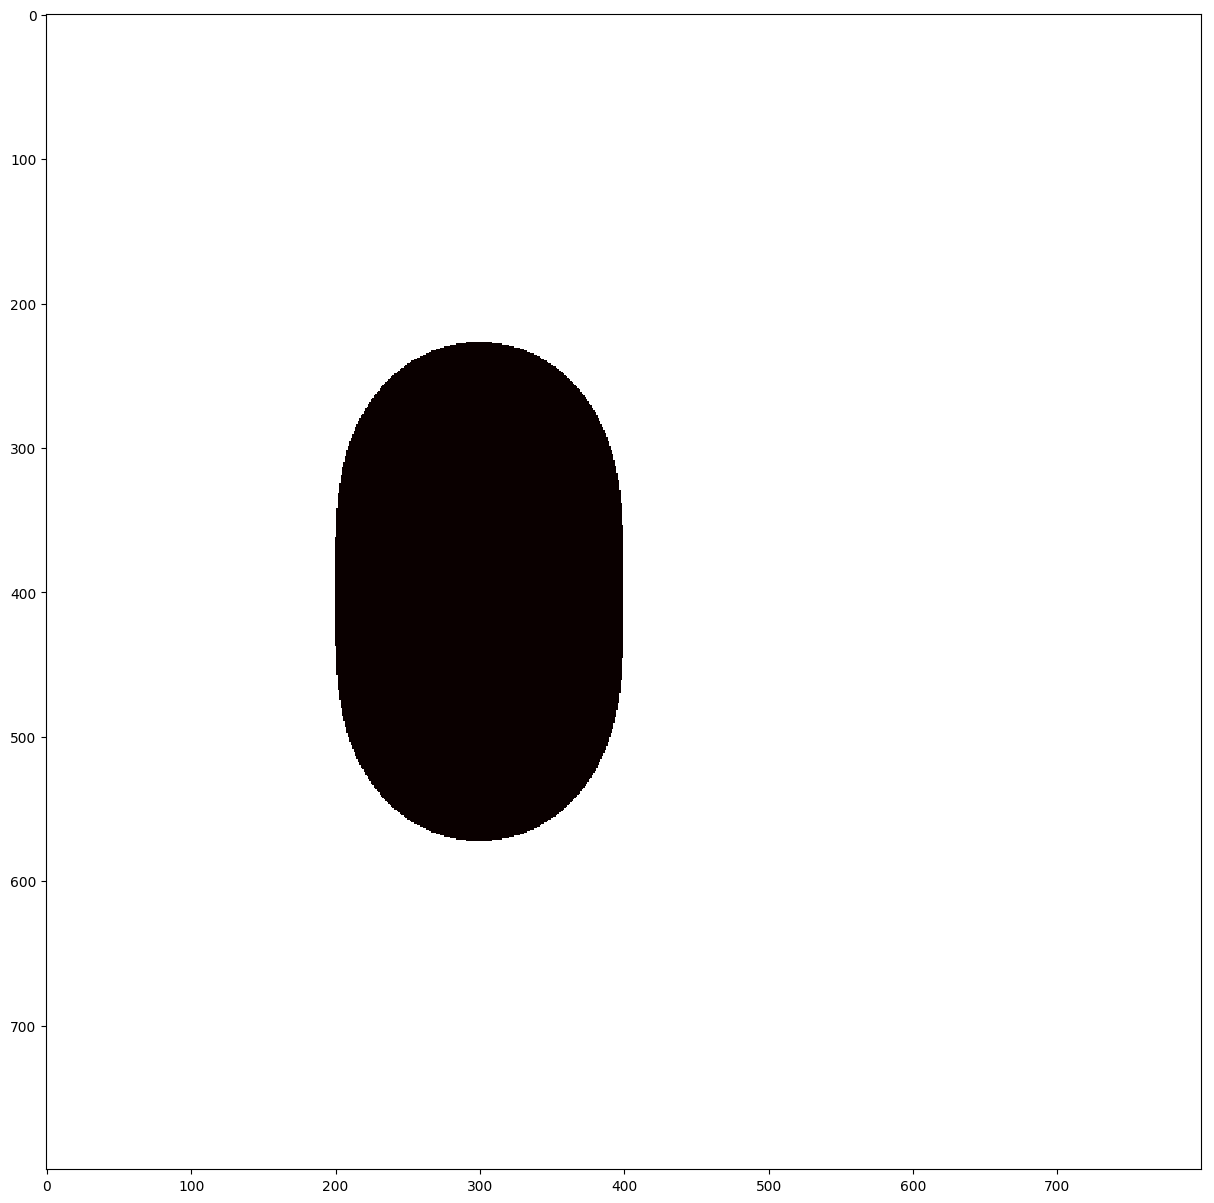

In [52]:
figure(figsize=(15,15))
imshow(S, cmap="hot");